# Exercise 1: Train a Small Encoder and Introduction to _hls4ml_

## Objectives
In this exercise, you will:
1. Train a simplified version of the Autoencoder
2. Learn the basics of _hls4ml_

## Instructions
Complete the code cells marked with `# TODO` comments. Follow the hints provided.

## Part 1: Environment Setup and Data Loading
Run the following cells to set up the environment (no changes needed).

In [1]:
# Load libraries and import packages (no changes needed)

# General imports
import os

# Numpy and plotting
import numpy as np
import matplotlib.pyplot as plt

# TimeSeries to hold our data
from gwpy.timeseries import TimeSeries

# Keras for the model
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, Input, InputLayer
from keras.optimizers import Nadam, Adam, SGD
from keras import regularizers

# Local file with some useful methods
from utils import *

# hls4ml
import hls4ml

# Set the correct libraries path for hls4ml
os.environ['XILINX_HLS']    = '/opt/tools/Xilinx/Vitis_HLS/2023.2'
os.environ['XILINX_VIVADO'] = '/opt/tools/Xilinx/Vivado/2023.2'
os.environ['XILINX_VITIS']  = '/opt/tools/Xilinx/Vitis/2023.2'
os.environ['PATH'] = os.environ["PATH"] + ":" \
                   + os.environ['XILINX_HLS'] + "/bin:" \
                   + os.environ['XILINX_VIVADO'] + "/bin:" \
                   + os.environ['XILINX_VITIS'] + "/bin:"

print("Environment setup correctly!")

2025-11-22 08:04:29.814403: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-22 08:04:29.816672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-22 08:04:29.847448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-22 08:04:29.847510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-22 08:04:29.847533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Environment setup correctly!


Load the data needed to train the encoder.

In the first exercise you analyzed 1 full second of data, now we only want to analyze 64 input datapoints and compress them down to dimension 8.

In [2]:
# SOLUTION: Load the input data
chunks = load_data("/data/input_data/AI_INFN/gwdata", nfiles=100, target_shape=64, normalize=True)

print(f"Loaded {chunks.shape[0]} samples with shape: {chunks[0].shape}")

Loaded 204800 samples with shape: (64, 1)


## Part 2: Train a small encoder
FPGAs have limited resources and the more resources are required by your design, the more time _hls4ml_ will need to produce a firmware. <br>
Additionally, the FPGA board that we are targetting for this exercise (`AMD Alveo U55c`) is quite large, increasing further the compilation time.

### Task 2.1: Define the Autoencoder
In order to fit within the hands-on session today we will focus on a small encoder of fully connected dense layers (no Convolution):
- 64 inputs
- Few hidden layers
- 8 "encoded" outputs

**Important:** Remember to name all your layers, it will be useful when optimizing the model! <br>
Example:
```python
model.Add(
    Dense(
            64,                 # N Neurons
            activation='tanh',  # Activation
            name="encoder1"     # Name of the layer
    )
)
```

In [3]:
# Solution: Define a "small" autoencoder whith the structure:
# 64 inputs --> [64, 32, 32, 16] --> latent dimension 8 --> [16, 32, 64] --> 64 outputs

# Define an autoencoder with dense leyers only
def autoencoder_model(input_dim=128, _num_neurons=64, _latent_dim=16, _dropout=0, bias1=0, bias2=0, ker1=0, ker2=0):

    # ====== Encoder ======
    encoder = Sequential(name="encoder")

    # Flatten
    encoder.add(Flatten(input_shape=(input_dim, 1), name="flatten"))

    # Encoding
    encoder.add(Dense(
        _num_neurons // 1, # 64 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="encoder1")
    )
    encoder.add(Dropout(_dropout, name="dropout1"))
    encoder.add(Dense(
        _num_neurons // 2, # 32 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="encoder2")
    )
    encoder.add(Dropout(_dropout, name="dropout2"))
    encoder.add(Dense(
        _num_neurons // 2, # 32 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="encoder3")
    )
    encoder.add(Dropout(_dropout, name="dropout3"))
    encoder.add(Dense(
        _num_neurons // 4, # 16 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="encoder4")
    )
    encoder.add(Dropout(_dropout, name="dropout4"))
    
    # Latent layer
    encoder.add(Dense(
        _latent_dim,       # 8 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="encoder5")
    )

    # ====== Decoder ======
    decoder = Sequential(name="decoder")

    # Decoding
    decoder.add(Dense(
        _num_neurons // 4, # 16 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="decoder1")
    )
    decoder.add(Dropout(_dropout, name="dropout1"))
    decoder.add(Dense(
        _num_neurons // 2, # 32 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="decoder2")
    )
    decoder.add(Dropout(_dropout, name="dropout2"))
    decoder.add(Dense(
        _num_neurons // 1, # 64 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="decoder3")
    )
    decoder.add(Dropout(_dropout, name="dropout3"))

    # Final layer
    decoder.add(Dense(
        input_dim,         # 64 Neurons
        activation='tanh',
        bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2),
        kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2),
        name="decoder4")
    )
    decoder.add(Dropout(_dropout, name="dropout4"))
    
    # Reshape
    decoder.add(Reshape((input_dim, 1), name="reshape"))

    # ====== Full Autoencoder ======
    # Input shape layer
    input_signal = Input(shape=(input_dim, 1), name="input")

    # Structure: input -> encoder -> decoder -> output
    encoded = encoder(input_signal)
    decoded = decoder(encoded)
    autoencoder = Model(inputs=input_signal, outputs=decoded, name="autoencoder")
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])

    # Return both the full model and the encoder/decoder
    return autoencoder, decoder, encoder

In [4]:
# Solutoin: declare your model and visualize it

# Model parameters
input_dim  = 64
latent_dim = 8
start_num_neuron = 64
dropout=0.1

# Define model
(autoencoder, decoder, encoder) = autoencoder_model(
    input_dim=input_dim, _num_neurons=start_num_neuron, _latent_dim=latent_dim,
    _dropout=dropout, bias1=0.3, bias2=0.3, ker1=0, ker2=0
)

# And visualize it
print("\n - AUTOENCODER -")
autoencoder.summary()
print("\n - ENCODER -")
encoder.summary()
print("\n - DECODER -")
decoder.summary()


 - AUTOENCODER -
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 1)]           0         
                                                                 
 encoder (Sequential)        (None, 8)                 7960      
                                                                 
 decoder (Sequential)        (None, 64, 1)             6960      
                                                                 
Total params: 14920 (58.28 KB)
Trainable params: 14920 (58.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

 - ENCODER -
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64)                0         
                                    

### Task 2.2: Train the Autoencoder

In [6]:
# SOLUTION: train the model

# Training parameters
epochs = 10

# Actual training
history = autoencoder.fit(chunks, chunks, epochs=epochs, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/10
5760/5760 [==============================] - 13s 2ms/step - loss: 0.0872 - mse: 0.0862 - val_loss: 0.0130 - val_mse: 0.0119
Epoch 2/10
5760/5760 [==============================] - 11s 2ms/step - loss: 0.0638 - mse: 0.0628 - val_loss: 0.0109 - val_mse: 0.0099
Epoch 3/10
5760/5760 [==============================] - 12s 2ms/step - loss: 0.0614 - mse: 0.0603 - val_loss: 0.0105 - val_mse: 0.0095
Epoch 4/10
5760/5760 [==============================] - 12s 2ms/step - loss: 0.0601 - mse: 0.0591 - val_loss: 0.0101 - val_mse: 0.0091
Epoch 5/10
5760/5760 [==============================] - 12s 2ms/step - loss: 0.0593 - mse: 0.0582 - val_loss: 0.0098 - val_mse: 0.0088
Epoch 6/10
5760/5760 [==============================] - 13s 2ms/step - loss: 0.0583 - mse: 0.0573 - val_loss: 0.0097 - val_mse: 0.0087
Epoch 7/10
5760/5760 [==============================] - 13s 2ms/step - loss: 0.0575 - mse: 0.0564 - val_loss: 0.0091 - val_mse: 0.0080
Epoch 8/10
5760/5760 [==============================] -

### Task 2.3: Save the Autoencoder
We will check its performance later, for now we just save the model.

In [7]:
# Ensure output directory exists (no changes needed)
if not os.path.exists('small_model'):
    os.makedirs('small_model')

# Save all three models
encoder    .save("small_model/small_encoder.keras"    , save_format="keras_v3")
decoder    .save("small_model/small_decoder.keras"    , save_format="keras_v3")
autoencoder.save("small_model/small_autoencoder.keras", save_format="keras_v3")

We also save a small subset of the input data that we can use later to test our converted model:

In [8]:
# Save 2000 events for testing (no changes needed)
X_test = chunks[:2000]
np.save('X_test.npy', X_test)

print(f"{X_test.shape[0]} test events (with shape {X_test[0].shape}) have been saved to X_test.npy")

2000 test events (with shape (64, 1)) have been saved to X_test.npy


## Part 3: _hls4ml_ Basics
We will now use the _hls4ml_ library to convert our encoder to a low latency firmware to be run on the FPGA.
This process has few steps:
-  Define an hls4ml config
-  Convert the model using the config
-  Compile
-  Build the firmware

For additional details:
- here is the official documentation: https://fastmachinelearning.org/hls4ml/index.html
- here is the GitHub page: https://github.com/fastmachinelearning/hls4ml

### Task 3.1: _hls4ml_ Configuration Files
We first define the _hls4ml_ config files needed to translate our model into a firmware. <br>
We need two configs:
- `hls_config`: to control the conversion options of the model
   - here is where we will mostly optimize our framework 
- `main_config`: which contains
   - to specify the details of the FPGA board we are targeting
   - the hls_config
   - the model
   - some I/O options

In [9]:
# Define a default hls config and inspect it (no changes needed)
hls_config = hls4ml.utils.config_from_keras_model(encoder, granularity='model')

print("="*20, "HLS Config", "="*20)
print_dict(hls_config)
print("="*50)

# You will see a few parameters that can be customized:
#  - `Precision`: the bit-wise representation of all the numbers in the model
#  - `ReuseFactor`: a mechanism to tune out firmware parallelism
#  - `Strategy`: how _hls4ml_ should do the conversion, if targeting resources- or latency-optimization
# In the next exercise we will explore some of them and verify what is their impact the model outputs.

==================== HLS Config ====================
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False


In [11]:
# SOLUTION: fix the missing parameters in the main_config

# Main config
main_cfg = hls4ml.converters.create_config(
    board = 'alveo-u55c',            # Target boad                           - DO NOT CHANGE
    part = 'xcu55c-fsvh2892-2L-e',   # Target FPGA part                      - DO NOT CHANGE
    clock_period = 3,                # Clock period in ns (i.e. ~333 MHz)
    backend = 'VivadoAccelerator'    # Backend to convert the NN in firmware - DO NOT CHANGE
)

# Few more customizations
main_cfg['HLSConfig'] = hls_config
main_cfg['IOType'] = 'io_parallel'                                                # DO NOT CHANGE
main_cfg['AcceleratorConfig']['Platform'] = 'xilinx_u55c_gen3x16_xdma_3_202210_1' # DO NOT CHANGE
main_cfg['KerasModel'] = encoder
main_cfg['OutputDir'] = 'small_model/small_encoder'

# Inspect final config
print("="*20, "Main Config", "="*20)
print_dict(main_cfg)
print("="*50)

==================== Main Config ====================
OutputDir:           small_model/small_encoder
ProjectName:         myproject
Backend:             VivadoAccelerator
Version:             1.0.0
Part:                xcu55c-fsvh2892-2L-e
ClockPeriod:         3
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
  Model
    Precision
      default:       fixed<16,6>
    ReuseFactor:     1
    Strategy:        Latency
    BramFactor:      1000000000
    TraceOutput:     False
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False
  TBOutputStream:    both
AcceleratorConfig
  Board:             alveo-u55c
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float
  Platform:          xilinx_u55c_gen3x16_xdma_3_202210_1
KerasModel:          <keras.src.engine.sequential.Sequential object at 0x7f9218f4f640>


### Task 3.2: HLS Model and Inference
We are now ready to define an hls model, compile it and run some inference.

In [12]:
# SOLUTION: declare the HLS model and run inference on the test data

# Define the hls model
hls_model = hls4ml.converters.keras_v2_to_hls(main_cfg)

# Compile it
hls_model.compile()

# Run inference
y_cpu = encoder.predict(X_test)
y_hls = hls_model.predict(X_test)

# Save predictions for later comparisons
np.save('y_cpu.npy', y_cpu)
np.save('y_hls.npy', y_hls)
print("Software predictions saved as 'y_cpu.npy' and 'y_hls.npy'.")

63/63 [==============================] - 0s 886us/step
Software predictions saved as 'y_cpu.npy' and 'y_hls.npy'.


### Task 3.3: Calculate Comparison Metrics
Calculate metrics to compare the hardware and software predictions:
- Mean Squared Error (MSE) per sample
- Overall MSE
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

In [13]:
# SOLUTION: Calculate comparison metrics

# MSE per sample: mean squared error for each sample across all features
mse_per_sample = np.mean((y_cpu - y_hls)**2, axis=1)

# Overall MSE: average of all MSE values
overall_mse = np.mean(mse_per_sample)

# MAE: mean absolute error across all predictions
mae = np.mean(np.abs(y_cpu - y_hls))

# RMSE: square root of overall MSE
rmse = np.sqrt(overall_mse)

# Print the metrics
print(f"\n=== Software vs Hardware Reconstruction Metrics ===")
print(f"Overall MSE           : {overall_mse:.6f}")
print(f"Average MSE per sample: {np.mean(mse_per_sample):.6f}")
print(f"Min MSE               : {np.min(mse_per_sample):.6f}")
print(f"Max MSE               : {np.max(mse_per_sample):.6f}")
print(f"Mean Absolute Error   : {mae:.6f}")
print(f"RMSE                  : {rmse:.6f}")

print(f"\nInterpretation:")
print(f"  - Lower values indicate better agreement between HW and SW")
print(f"  - The differences are due to quantization in the FPGA implementation")


=== Software vs Hardware Reconstruction Metrics ===
Overall MSE           : 0.000798
Average MSE per sample: 0.000798
Min MSE               : 0.000257
Max MSE               : 0.002208
Mean Absolute Error   : 0.022396
RMSE                  : 0.028256

Interpretation:
  - Lower values indicate better agreement between HW and SW
  - The differences are due to quantization in the FPGA implementation


### Task 3.4: Visualize the Comparison
Create visualizations to compare CPU and HLS predictions.


Comparison plot saved as 'cpu_hls_emulation_comparison.png'


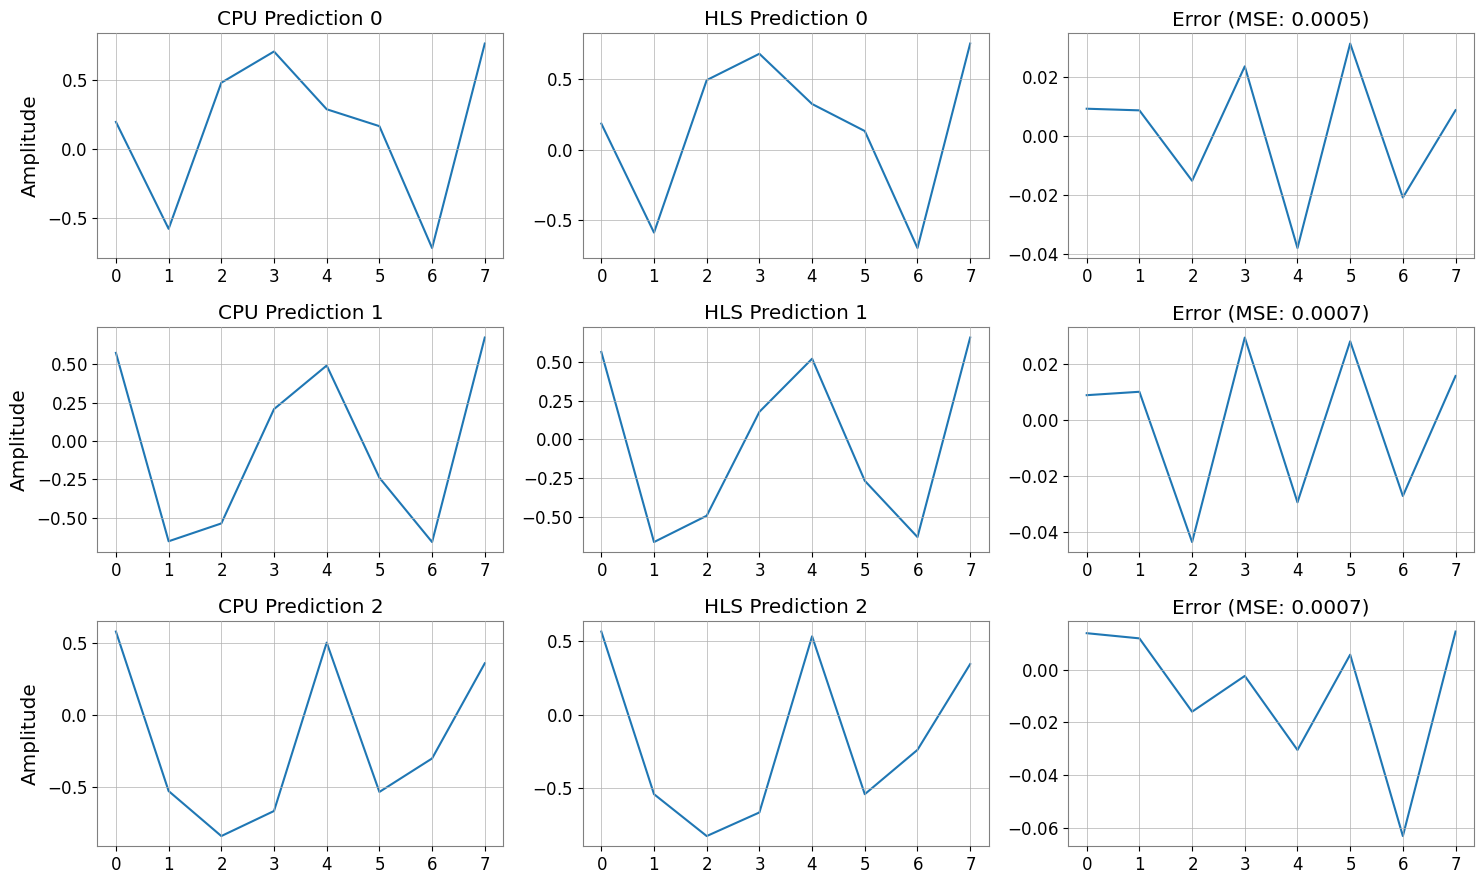

In [14]:
# Visualize comparison for first 3 samples (no changes needed)
n_examples = 3
fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3*n_examples))

for i in range(n_examples):
    # CPU predictions
    axes[i, 0].plot(y_cpu[i])
    axes[i, 0].set_title(f'CPU Prediction {i}')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True)
    
    # HLS predictions
    axes[i, 1].plot(y_hls[i])
    axes[i, 1].set_title(f'HLS Prediction {i}')
    axes[i, 1].grid(True)
    
    # Difference
    axes[i, 2].plot(y_cpu[i] - y_hls[i])
    axes[i, 2].set_title(f'Error (MSE: {mse_per_sample[i]:.4f})')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.savefig('cpu_hls_comparison.png')
print("\nComparison plot saved as 'cpu_hls_emulation_comparison.png'")

Error distribution plot saved as 'emulation_error_distribution.png'


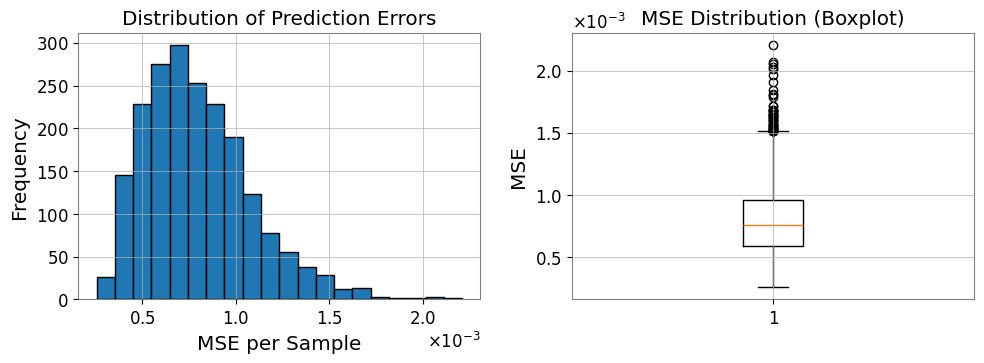

In [15]:
# Visualize error distribution (no changes needed)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(mse_per_sample, bins=20, edgecolor='black')
plt.xlabel('MSE per Sample')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(mse_per_sample)
plt.ylabel('MSE')
plt.title('MSE Distribution (Boxplot)')
plt.grid(True)

plt.tight_layout()
plt.savefig('error_distribution.png')
print("Error distribution plot saved as 'emulation_error_distribution.png'")

## Part 4: Synthesize the Model
The last step of this exercise is to run the synthesis of the model.

In this step `hls4ml` uses the Vivado/Vitis_HLS libraries to convert the Neural Network into the electrical circuit that will be loaded on the FPGA. After this step we will have a first estimate of how many resources our project will need and what will be the latency.

**Important:** This step takes 5-10 minutes depending on how many layers/neurons you have used, so fix the cell below and run it now!

### Bonus:
The `build ` method potentially takes many more parameters:
```python
hls_model.build(
    csim          = False, # Run C++ emulation
    synth         = True,  # Run Synthesis
    export        = True,  # Run Synthesis + Implementation + packaging into custo IP
    export_xo     = True,  # Build an .xo file for integration in larger project
    export_bitfile= True   # Build an .xlcbin file for direct board deployment
)
```
Building a full `.xlcbin` file might require several hours! In the last exercise today (`notebook3`) you will use some pre-compiled firmwares to run inference on the real `Alveo U55c` boards.

In [16]:
# SOLUTION: use the same output dir that you have used in the main_cfg

# Run the synthesis
hls_model.build(csim=False) # -- DO NOT CHANGE

# Print the reports
print("Resource usage and latency:")
print_report('small_model/small_encoder')


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.2 (64-bit)
  **** SW Build 4023990 on Oct 11 2023
  **** IP Build 4028589 on Sat Oct 14 00:45:43 MDT 2023
  **** SharedData Build 4025554 on Tue Oct 10 17:18:54 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/tools/Xilinx/Vitis_HLS/2023.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/tools/Xilinx/Vitis_HLS/2023.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'fbrivio' on host '0a14f8543b53' (Linux_x86_64 version 5.4.0-169-generic) on Sat Nov 22 08:19:40 UTC 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/fbrivio/hackathon/small_model/small_encoder'
INFO: [HLS 200-2053] The vitis_hls executable is being deprecated. Consider using vitis-run --mode hls --tcl
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_projec